# INFO2950 Final Project

## Background Information

The pursuit of a college education has consistently been tied to graduates' financial success compared to non-graduates; on average, graduates are 1/2 as likely to be unemployed and have 84% higher income than those whose highest education is a high school diploma. Every year, high school graduates have to decide if the cost of college -- both tuition _and_ being out of the workforce for 4 years -- is worth the financial benefit. On top of the decision to attend, they must choose a major, a decision that could determine the degree of their financial success and the magnitude of benefits reaped from attending college.

However, this relationship is highly generalized. Not every degree concentration yields the same average financial success as others. For example, a degree in computer science or another form of engineering leads to a job market that has, on average, higher salaries than a degree in English.

A typical reason why a certain major's salary would be important to a college graduate is that many come to college for upward mobility. College is seen by many as a pathway to a higher financial and social standing as well as a higher quality of life. This extends further than simply their post-graduation salary, but the mean income of the location in which they live, as quality of life is largely affected by the wealth of those around you, as it impacts the opportunities available, public school funding, health, and much more. Perhaps the mean income of postgraduates' region of residence indicates the degree of their major's impact on their financial success and quality of life.

Thus, we are interested in exploring the relationship between the college major of a college postgraduate and the wealth of their county of residence. We decided we were most interested in exploring this relationship within New York State, where there is a _dramatic_ wealth gap between its most affluent regions (for example, New York City) versus its most poor regions; in fact, New York was recognized as the state with the highest gap between the rich and the poor, with a Gini coefficient score in 2022 of 0.52.


## Research Question

Question: Can we reliably predict a New York county's wealth based on their percentage of postgraduates of a certain age and major?

At the conclusion of this project, we seek to determine if there is a correlation between college major and the per capita income of the postgraduate county of residence in New York, and age and the per capita income of the postgraduate county of residence in New York. We will train a multivariable regression on data tables from both Wikepedia and the U.S. Census Bureau to see if we can reliably predict a county's per capita income given the population percentages of Science and Engineering, Business, Education, and Arts, Humanities, and Others for each of these age groups: 25-39 years, 40-64 years, and 65 years and over. Essentially, we aim to determine if college major and age affects the average wealth of where people live.

We defined county wealth using per capita income of the county and we solely considered New York counties for our regression. We defined postgraduates as people holding a Bachelor's degree who is at least 25 years old. 

## Original Data Description

We have two data tables from the U.S. Census Bureau and Wikepedia. 

Our data from Wikepedia:
https://en.wikipedia.org/wiki/List_of_New_York_locations_by_per_capita_income.

- Each row (observation) is a New York State county
- There are two columns (attributes) and they are: the county name and the county's per capita income. Before we copy-pasted it, the original dataframe on the website had additional columns for median household income, median family income, population, and number of households. We omitted these columns because they did not serve a purpose in our regression
- This dataset was created by Wikepedia to inform the public of the income per capita of each county in New York State
- The data is originally from the 2010 United States Census Data and the 2006-2010 American Community Survey 5-Year Estimates. The data from the Census is created, funded, and collected by the United States government for the purposes of better understanding the demographics of the country and informing policy
- Since this was a survey, the process of a voluntary survey may have influenced which data was actually gathered, since some may have declined to share their data or others may not have been within reach of or had access to the survey
- Those who participated were aware their data was going to be used for analyzing demographics
- We collected this data through copying and pasting the data into an Excel sheet and downloading it as a .csv file

Our data from the U.S. Census Bureau: https://data.census.gov/table/ACSST1Y2022.S1502?g=040XX00US36,36 using New York State (as a whole) and all New York Counties as filters for their data set, created in 2022.

- The rows (observations) each represented one person surveyed, categorized by age range and college major.
- The columns (attributes) are described below:
    - The first column houses the labels of groups of people by age and college major; the following columns pre- data cleaning have each county and the general state's estimate of people falling into each category, the margin of error, percent estimate, percent error, male estimate, male margin of error, male percent estimate, male percent margin of error, female estimate, female margin of error, female percent estimate, and female percent margin of error
- This dataset was created to gather information about the residents of the United States to better understand the demographics of the country and created more informed policy
- This data was created, funded, and collected by the government of the United States as a part of the Census, a large survey taken every 10 years
- Those who participated in the Census were aware that their data was being used to better understand demographics
- Since this was a survey, the process of a voluntary survey may have influenced which data was actually gathered, since some may have declined to share their data or been without access to complete the survey
- There are 5 rows and 469 columns, full of numerical data. No information is missing and the data is self-contained. The data identifies subpopulations by age and gender. Age is used to further divide the groups of majors and gender is used to divide each county's data
- This data was accessed using filters to narrow down the dataset to the variables: age, college major, and county

## Data Cleaning and Collection

### Importing packages

In [1904]:
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, KFold, cross_val_score
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

### Data cleaning: selecting and extracting the relevant columns of U.S. Census Bureau data table and renaming columns

Read the .csv file:

In [1905]:
census_majors = pd.read_csv("nys_counties_college.csv")
census_majors.columns = census_majors.columns.str.replace(
    "    ", "")

Below, we see that there are many columns that are not relevant to our research question. We are only interested in each county's percent estimate column.

In [1906]:
print(census_majors.head())

                                    Label (Grouping)  \
0  Total population 25 years and over with a Bach...   
1                            Science and Engineering   
2             Science and Engineering Related Fields   
3                                           Business   
4                                          Education   

  New York!!Total!!Estimate New York!!Total!!Margin of Error  \
0                 5,556,561                          ±33,405   
1                 1,951,557                          ±21,418   
2                   513,403                          ±13,232   
3                 1,036,287                          ±19,358   
4                   560,313                          ±13,635   

  New York!!Percent!!Estimate New York!!Percent!!Margin of Error  \
0                         (X)                                (X)   
1                      35.10%                               ±0.4   
2                       9.20%                               ±0.2   
3     

Below, we are replacing the !!s and the spaces with an underscore, then selecting the relevant columns which have each county's total percentage (not including the columns regarding margin or error, total estimate, NYS as a whole, or Male/Female specific columns). There were a lot of columns to be dropped (more than half), so after trying to use .drop(), a TA helped us realize we should just extract the columns of interest and put it into a new dataframe, which we called census_majors_cleaned. We then rename the suffix of each column, _New_York_Percent_Estimate, to County so that we have [name] County as each column's name, so the column names are consistent with the County column of the Wikepedia dataframe.

In [1907]:
census_majors.columns = census_majors.columns.str.replace(
    "!!", "_")
census_majors.columns = census_majors.columns.str.replace(
    " ", "_")
#Checking that the column names are correct
display(census_majors)

,Label_(Grouping),New_York_Total_Estimate,New_York_Total_Margin_of_Error,New_York_Percent_Estimate,New_York_Percent_Margin_of_Error,New_York_Male_Estimate,New_York_Male_Margin_of_Error,New_York_Percent_Male_Estimate,New_York_Percent_Male_Margin_of_Error,New_York_Female_Estimate,...,"Westchester_County,_New_York_Percent_Estimate","Westchester_County,_New_York_Percent_Margin_of_Error","Westchester_County,_New_York_Male_Estimate","Westchester_County,_New_York_Male_Margin_of_Error","Westchester_County,_New_York_Percent_Male_Estimate","Westchester_County,_New_York_Percent_Male_Margin_of_Error","Westchester_County,_New_York_Female_Estimate","Westchester_County,_New_York_Female_Margin_of_Error","Westchester_County,_New_York_Percent_Female_Estimate","Westchester_County,_New_York_Percent_Female_Margin_of_Error"
0,Total population 25 years and over with a Bach...,"5,556,561","±33,405",(X),(X),"2,561,363","±21,001",(X),(X),"2,995,198",...,(X),(X),"168,019","±4,967",(X),(X),"197,801","±5,213",(X),(X)
1,Science and Engineering,"1,951,557","±21,418",35.10%,±0.4,"1,085,529","±16,174",42.40%,±0.6,"866,028",...,36.60%,±1.5,"70,551","±3,957",42.00%,±2.4,"63,221","±4,230",32.00%,±2.0
2,Science and Engineering Related Fields,"513,403","±13,232",9.20%,±0.2,"138,737","±6,246",5.40%,±0.2,"374,666",...,8.20%,±0.9,"7,169","±1,521",4.30%,±0.9,"22,775","±2,965",11.50%,±1.4
3,Business,"1,036,287","±19,358",18.60%,±0.3,"556,473","±13,673",21.70%,±0.5,"479,814",...,19.10%,±1.1,"37,741","±3,503",22.50%,±1.8,"32,236","±2,879",16.30%,±1.4
4,Education,"560,313","±13,635",10.10%,±0.2,"128,090","±6,084",5.00%,±0.2,"432,223",...,8.10%,±0.8,"4,763","±1,157",2.80%,±0.7,"24,851","±2,323",12.60%,±1.2
5,"Arts, Humanities and Others","1,495,001","±23,801",26.90%,±0.4,"652,534","±15,181",25.50%,±0.5,"842,467",...,28.00%,±1.3,"47,795","±3,654",28.40%,±1.9,"54,718","±4,107",27.70%,±1.9
6,DETAILED AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,25 to 39 years,"2,014,094","±21,802",(X),(X),"921,551","±14,714",(X),(X),"1,092,543",...,(X),(X),"44,714","±3,439",(X),(X),"50,929","±3,194",(X),(X)
8,Science and Engineering,"768,173","±14,817",38.10%,±0.7,"397,981","±10,089",43.20%,±1.0,"370,192",...,39.60%,±3.3,"18,701","±2,488",41.80%,±4.5,"19,139","±2,610",37.60%,±4.3
9,Science and Engineering Related Fields,"187,112","±7,607",9.30%,±0.4,"53,189","±4,136",5.80%,±0.4,"133,923",...,8.80%,±2.0,"2,399",±924,5.40%,±2.0,"6,049","±1,452",11.90%,±2.8


In [1908]:
census_majors_cleaned = census_majors[[
'Label_(Grouping)', 'Albany_County,_New_York_Percent_Estimate',
'Bronx_County,_New_York_Percent_Estimate',
'Broome_County,_New_York_Percent_Estimate',
'Cattaraugus_County,_New_York_Percent_Estimate',
'Cayuga_County,_New_York_Percent_Estimate',
'Chautauqua_County,_New_York_Percent_Estimate',
'Chemung_County,_New_York_Percent_Estimate',
'Clinton_County,_New_York_Percent_Estimate',
'Dutchess_County,_New_York_Percent_Estimate',
'Erie_County,_New_York_Percent_Estimate',
'Jefferson_County,_New_York_Percent_Estimate',
'Kings_County,_New_York_Percent_Estimate',
'Madison_County,_New_York_Percent_Estimate',
'Monroe_County,_New_York_Percent_Estimate',
'Nassau_County,_New_York_Percent_Estimate',
'New_York_County,_New_York_Percent_Estimate',
'Niagara_County,_New_York_Percent_Estimate',
'Oneida_County,_New_York_Percent_Estimate',
'Onondaga_County,_New_York_Percent_Estimate',
'Ontario_County,_New_York_Percent_Estimate',
'Orange_County,_New_York_Percent_Estimate',
'Oswego_County,_New_York_Percent_Estimate',
'Putnam_County,_New_York_Percent_Estimate',
'Queens_County,_New_York_Percent_Estimate',
'Rensselaer_County,_New_York_Percent_Estimate',
'Richmond_County,_New_York_Percent_Estimate',
'Rockland_County,_New_York_Percent_Estimate',
'St._Lawrence_County,_New_York_Percent_Estimate',
'Saratoga_County,_New_York_Percent_Estimate',
'Schenectady_County,_New_York_Percent_Estimate',
'Steuben_County,_New_York_Percent_Estimate',
'Suffolk_County,_New_York_Percent_Estimate',
'Sullivan_County,_New_York_Percent_Estimate',
'Tompkins_County,_New_York_Percent_Estimate',
'Ulster_County,_New_York_Percent_Estimate',
'Warren_County,_New_York_Percent_Estimate',
'Wayne_County,_New_York_Percent_Estimate',
'Westchester_County,_New_York_Percent_Estimate',
]]
#Confidence check: does the dataframe have the columns we want?
display(census_majors_cleaned)

,Label_(Grouping),"Albany_County,_New_York_Percent_Estimate","Bronx_County,_New_York_Percent_Estimate","Broome_County,_New_York_Percent_Estimate","Cattaraugus_County,_New_York_Percent_Estimate","Cayuga_County,_New_York_Percent_Estimate","Chautauqua_County,_New_York_Percent_Estimate","Chemung_County,_New_York_Percent_Estimate","Clinton_County,_New_York_Percent_Estimate","Dutchess_County,_New_York_Percent_Estimate",...,"Saratoga_County,_New_York_Percent_Estimate","Schenectady_County,_New_York_Percent_Estimate","Steuben_County,_New_York_Percent_Estimate","Suffolk_County,_New_York_Percent_Estimate","Sullivan_County,_New_York_Percent_Estimate","Tompkins_County,_New_York_Percent_Estimate","Ulster_County,_New_York_Percent_Estimate","Warren_County,_New_York_Percent_Estimate","Wayne_County,_New_York_Percent_Estimate","Westchester_County,_New_York_Percent_Estimate"
0,Total population 25 years and over with a Bach...,(X),(X),(X),(X),(X),(X),(X),(X),(X),...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
1,Science and Engineering,42.80%,32.90%,39.50%,34.50%,33.60%,30.70%,32.00%,26.30%,34.50%,...,43.00%,39.40%,36.20%,31.50%,31.70%,51.10%,29.50%,32.60%,39.20%,36.60%
2,Science and Engineering Related Fields,8.40%,11.70%,8.80%,8.30%,7.30%,14.00%,10.40%,12.10%,7.80%,...,7.60%,8.00%,11.40%,11.10%,7.70%,4.40%,5.50%,10.10%,11.00%,8.20%
3,Business,14.30%,19.70%,16.20%,16.60%,17.50%,11.80%,14.30%,14.30%,15.70%,...,17.20%,18.10%,14.90%,21.70%,11.20%,8.30%,16.10%,14.10%,17.80%,19.10%
4,Education,11.30%,10.50%,13.50%,20.40%,19.10%,19.50%,17.80%,22.50%,11.90%,...,11.00%,11.40%,15.40%,13.80%,15.30%,5.80%,12.10%,22.20%,15.10%,8.10%
5,"Arts, Humanities and Others",23.20%,25.20%,22.00%,20.20%,22.40%,24.00%,25.50%,24.80%,30.10%,...,21.30%,23.10%,22.10%,21.90%,34.10%,30.40%,36.90%,21.00%,17.00%,28.00%
6,DETAILED AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,25 to 39 years,(X),(X),(X),(X),(X),(X),(X),(X),(X),...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
8,Science and Engineering,47.00%,37.10%,43.00%,36.10%,34.60%,22.90%,45.00%,23.30%,38.70%,...,43.40%,48.80%,37.30%,34.90%,39.80%,55.50%,35.40%,36.30%,45.20%,39.60%
9,Science and Engineering Related Fields,9.90%,11.70%,9.20%,7.10%,5.80%,12.10%,14.00%,18.20%,8.90%,...,10.80%,5.50%,10.60%,12.60%,5.30%,1.90%,8.00%,18.20%,15.10%,8.80%


In [1909]:
#Getting rid of added title (we just want the county name + "County")
census_majors_cleaned.columns = census_majors_cleaned.columns.str.replace(
    ",_New_York_Percent_Estimate", "")
#Changing the _s to a space for more familiar names 
#(underscore is less familiar to us)
census_majors_cleaned.columns = census_majors_cleaned.columns.str.replace(
    "_", " ")
#Setting the index to be the majors so when we transpose the dataframe,
#the columns will be named with the majors
census_majors_cleaned.set_index('Label (Grouping)', inplace=True)
#Checking to make sure the dataframe has the index we want
display(census_majors_cleaned)

,Albany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Clinton County,Dutchess County,Erie County,...,Saratoga County,Schenectady County,Steuben County,Suffolk County,Sullivan County,Tompkins County,Ulster County,Warren County,Wayne County,Westchester County
Label (Grouping),,,,,,,,,,,,,,,,,,,,,
Total population 25 years and over with a Bachelor's degree or higher,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
Science and Engineering,42.80%,32.90%,39.50%,34.50%,33.60%,30.70%,32.00%,26.30%,34.50%,32.20%,...,43.00%,39.40%,36.20%,31.50%,31.70%,51.10%,29.50%,32.60%,39.20%,36.60%
Science and Engineering Related Fields,8.40%,11.70%,8.80%,8.30%,7.30%,14.00%,10.40%,12.10%,7.80%,11.40%,...,7.60%,8.00%,11.40%,11.10%,7.70%,4.40%,5.50%,10.10%,11.00%,8.20%
Business,14.30%,19.70%,16.20%,16.60%,17.50%,11.80%,14.30%,14.30%,15.70%,19.90%,...,17.20%,18.10%,14.90%,21.70%,11.20%,8.30%,16.10%,14.10%,17.80%,19.10%
Education,11.30%,10.50%,13.50%,20.40%,19.10%,19.50%,17.80%,22.50%,11.90%,12.70%,...,11.00%,11.40%,15.40%,13.80%,15.30%,5.80%,12.10%,22.20%,15.10%,8.10%
"Arts, Humanities and Others",23.20%,25.20%,22.00%,20.20%,22.40%,24.00%,25.50%,24.80%,30.10%,23.70%,...,21.30%,23.10%,22.10%,21.90%,34.10%,30.40%,36.90%,21.00%,17.00%,28.00%
DETAILED AGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25 to 39 years,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),...,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X)
Science and Engineering,47.00%,37.10%,43.00%,36.10%,34.60%,22.90%,45.00%,23.30%,38.70%,36.40%,...,43.40%,48.80%,37.30%,34.90%,39.80%,55.50%,35.40%,36.30%,45.20%,39.60%


We want to merge this data with the Wikepedia data, so we will align the county names as rows because a taller dataframe is better for regressions. We will use .transpose() to switch the columns and the rows of the cleaned census data. After performing that, we realized we have to set the index to our "Label (Grouping)" column, so we used set_index() above the transpose() command (in the cell above) so we could set the right column to be the index

In [1910]:
census_majors_cleaned = census_majors_cleaned.transpose()
display(census_majors_cleaned)

Label (Grouping),Total population 25 years and over with a Bachelor's degree or higher,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",DETAILED AGE,25 to 39 years,Science and Engineering,Science and Engineering Related Fields,...,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",65 years and over,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
Albany County,(X),42.80%,8.40%,14.30%,11.30%,23.20%,NaN,(X),47.00%,9.90%,...,7.70%,15.00%,11.00%,23.70%,(X),36.50%,7.30%,16.80%,21.60%,17.80%
Bronx County,(X),32.90%,11.70%,19.70%,10.50%,25.20%,NaN,(X),37.10%,11.70%,...,11.50%,21.20%,11.80%,25.00%,(X),29.10%,12.00%,13.10%,21.40%,24.40%
Broome County,(X),39.50%,8.80%,16.20%,13.50%,22.00%,NaN,(X),43.00%,9.20%,...,6.60%,22.00%,13.40%,20.70%,(X),38.70%,11.90%,11.90%,21.70%,15.70%
Cattaraugus County,(X),34.50%,8.30%,16.60%,20.40%,20.20%,NaN,(X),36.10%,7.10%,...,9.60%,18.50%,20.90%,19.00%,(X),36.80%,7.50%,17.20%,21.80%,16.70%
Cayuga County,(X),33.60%,7.30%,17.50%,19.10%,22.40%,NaN,(X),34.60%,5.80%,...,7.90%,22.80%,15.60%,16.10%,(X),26.20%,8.20%,13.00%,33.10%,19.50%
Chautauqua County,(X),30.70%,14.00%,11.80%,19.50%,24.00%,NaN,(X),22.90%,12.10%,...,13.00%,15.90%,17.20%,17.80%,(X),26.60%,17.50%,4.40%,26.20%,25.30%
Chemung County,(X),32.00%,10.40%,14.30%,17.80%,25.50%,NaN,(X),45.00%,14.00%,...,5.40%,22.20%,19.30%,27.10%,(X),27.40%,14.60%,14.60%,29.90%,13.50%
Clinton County,(X),26.30%,12.10%,14.30%,22.50%,24.80%,NaN,(X),23.30%,18.20%,...,9.20%,16.90%,18.10%,27.70%,(X),26.30%,10.60%,8.70%,33.60%,20.90%
Dutchess County,(X),34.50%,7.80%,15.70%,11.90%,30.10%,NaN,(X),38.70%,8.90%,...,6.20%,20.40%,11.20%,29.30%,(X),32.00%,9.30%,9.50%,21.70%,27.50%
Erie County,(X),32.20%,11.40%,19.90%,12.70%,23.70%,NaN,(X),36.40%,11.10%,...,11.50%,22.40%,12.20%,23.70%,(X),29.10%,12.00%,13.60%,22.70%,22.60%


Now we have to create an index for the rows, because we want the county to be a column rather than an index, since we cannot use a County index like we would with a column as a key when merging dataframes.

In [1911]:
census_majors_cleaned.reset_index(inplace=True)
census_majors_cleaned.rename(
    columns = {'index':'County'}, inplace = True)
display(census_majors_cleaned)

Label (Grouping),County,Total population 25 years and over with a Bachelor's degree or higher,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",DETAILED AGE,25 to 39 years,Science and Engineering,...,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",65 years and over,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,Albany County,(X),42.80%,8.40%,14.30%,11.30%,23.20%,NaN,(X),47.00%,...,7.70%,15.00%,11.00%,23.70%,(X),36.50%,7.30%,16.80%,21.60%,17.80%
1,Bronx County,(X),32.90%,11.70%,19.70%,10.50%,25.20%,NaN,(X),37.10%,...,11.50%,21.20%,11.80%,25.00%,(X),29.10%,12.00%,13.10%,21.40%,24.40%
2,Broome County,(X),39.50%,8.80%,16.20%,13.50%,22.00%,NaN,(X),43.00%,...,6.60%,22.00%,13.40%,20.70%,(X),38.70%,11.90%,11.90%,21.70%,15.70%
3,Cattaraugus County,(X),34.50%,8.30%,16.60%,20.40%,20.20%,NaN,(X),36.10%,...,9.60%,18.50%,20.90%,19.00%,(X),36.80%,7.50%,17.20%,21.80%,16.70%
4,Cayuga County,(X),33.60%,7.30%,17.50%,19.10%,22.40%,NaN,(X),34.60%,...,7.90%,22.80%,15.60%,16.10%,(X),26.20%,8.20%,13.00%,33.10%,19.50%
5,Chautauqua County,(X),30.70%,14.00%,11.80%,19.50%,24.00%,NaN,(X),22.90%,...,13.00%,15.90%,17.20%,17.80%,(X),26.60%,17.50%,4.40%,26.20%,25.30%
6,Chemung County,(X),32.00%,10.40%,14.30%,17.80%,25.50%,NaN,(X),45.00%,...,5.40%,22.20%,19.30%,27.10%,(X),27.40%,14.60%,14.60%,29.90%,13.50%
7,Clinton County,(X),26.30%,12.10%,14.30%,22.50%,24.80%,NaN,(X),23.30%,...,9.20%,16.90%,18.10%,27.70%,(X),26.30%,10.60%,8.70%,33.60%,20.90%
8,Dutchess County,(X),34.50%,7.80%,15.70%,11.90%,30.10%,NaN,(X),38.70%,...,6.20%,20.40%,11.20%,29.30%,(X),32.00%,9.30%,9.50%,21.70%,27.50%
9,Erie County,(X),32.20%,11.40%,19.90%,12.70%,23.70%,NaN,(X),36.40%,...,11.50%,22.40%,12.20%,23.70%,(X),29.10%,12.00%,13.60%,22.70%,22.60%


Now we are ready to split this data into other subgroups and merge that data with the Wikepedia data!
Note: we know we have NaNs in our dataframe, but we will solely be using this dataframe to extract columns from, so we will be "cleaning" the NaNs out by not using those columns (since the columns of NaNs serve to show which columns are for which age)

### Data collection: Excel and downloading the Wikepedia table

In [1912]:
wikepedia_url = "https://en.wikipedia.org/wiki/List_of_New_York_locations_by_per_capita_income"

In [1913]:
wikepedia_result = requests.get(wikepedia_url)

In [1914]:
with open("county_wealth.html", "w") as writer:
    writer.write(wikepedia_result.text)

In [1915]:
with open("county_wealth.html", "r") as reader:
    html_source = reader.read()

In [1916]:
# Confidence check
html_source[:20]

'<!DOCTYPE html>\n<htm'

In [1917]:
page = BeautifulSoup(html_source, "html.parser")

Below, you will find that there are no classes in the < tr > tags that we scraped.

In [1918]:
wikepedia_county_income = page.find("table", 
                                    {"class": "wikitable"})
wikepedia_county_income = wikepedia_county_income.find_next(
    'tbody').find_all('tr')
print(wikepedia_county_income)

[<tr valign="bottom">
<th>Rank
</th>
<th>County
</th>
<th>Per capita<br/>income
</th>
<th>Median<br/>household<br/>income
</th>
<th>Median<br/>family<br/>income
</th>
<th>Population
</th>
<th>Number of<br/>households
</th></tr>, <tr>
<td>1
</td>
<td><a href="/wiki/Manhattan" title="Manhattan">New York County</a>
</td>
<td>$111,386
</td>
<td>$64,971
</td>
<td>$75,629
</td>
<td>1,585,873
</td>
<td>763,846
</td></tr>, <tr>
<td>2
</td>
<td><a href="/wiki/Westchester_County,_New_York" title="Westchester County, New York">Westchester</a>
</td>
<td>$73,159
</td>
<td>$79,619
</td>
<td>$100,863
</td>
<td>949,113
</td>
<td>347,232
</td></tr>, <tr>
<td>3
</td>
<td><a href="/wiki/Nassau_County,_New_York" title="Nassau County, New York">Nassau</a>
</td>
<td>$41,387
</td>
<td>$93,613
</td>
<td>$107,934
</td>
<td>1,339,532
</td>
<td>448,528
</td></tr>, <tr>
<td>4
</td>
<td><a href="/wiki/Putnam_County,_New_York" title="Putnam County, New York">Putnam</a>
</td>
<td>$37,915
</td>
<td>$89,218
</td>
<td>

We attempted to data scrape the Wikepedia website, but we were unsuccessful because the < tr > tags that contained the data we were trying to scrape did not have a class associated with them, and TAs we consulted recommended manually pasting the data into an Excel spreadsheet and downloading it as a .csv file instead.

Thus, we manually copy-pasted the Wikepedia data into Excel and downloaded that file as a .csv

In [1919]:
county_wealth = pd.read_csv("county_wealth.csv")
display(county_wealth)

,County,Per capita income
0,New York County,"111, 386"
1,Westchester,"73, 159"
2,Nassau,"41, 387"
3,Putnam,"37, 915"
4,Suffolk,"35, 755"
...,...,...
57,Wyoming,"20, 605"
58,St. Lawrence,"20, 143"
59,Allegany,"20, 058"
60,Franklin,"19, 807"


### Data Cleaning: Adding "County" to the county names in county_wealth

To perform an inner join on the tables, we have to rename each row of the "County" column of county_wealth, since the county name does not have "county" after it, as it does in census_majors' county columns.

In [1920]:
county_wealth['County'] = county_wealth['County'] + ' County'
county_wealth['County'].iloc[[0]] = 'New York County'
display(county_wealth)

,County,Per capita income
0,New York County,"111, 386"
1,Westchester County,"73, 159"
2,Nassau County,"41, 387"
3,Putnam County,"37, 915"
4,Suffolk County,"35, 755"
...,...,...
57,Wyoming County,"20, 605"
58,St. Lawrence County,"20, 143"
59,Allegany County,"20, 058"
60,Franklin County,"19, 807"


We also have to change the Per capita income column values from strings to integers.

In [1921]:
#Get rid of the commas and extra spaces in the values 
#so they can be converted to integers
county_wealth['Per capita income'] = county_wealth[
    'Per capita income'].str.replace('  ,', '')
county_wealth['Per capita income'] = county_wealth[
    'Per capita income'].str.replace(', ', '')
#Convert to int
county_wealth['Per capita income'] = county_wealth[
    'Per capita income'].astype(int)
#Confidence check - print the type of the column 
#and display the dataframe
print(county_wealth['Per capita income'].dtypes)
display(county_wealth)

int64


,County,Per capita income
0,New York County,111386
1,Westchester County,73159
2,Nassau County,41387
3,Putnam County,37915
4,Suffolk County,35755
...,...,...
57,Wyoming County,20605
58,St. Lawrence County,20143
59,Allegany County,20058
60,Franklin County,19807


### Data cleaning: splitting census data

Here we are splitting the data into two subsets:
- One dataframe where the age is disregarded and all of the ages are compiled into one major, so that there is one value for each major (ageless_majors)
- Three dataframes where each age is displayed in full on its own (young_majors, middle_majors, old_majors)

After we create these, we display each dataframe and then merge it with the wikepedia dataframe. We want to merge this via a left join to combine the data unique to each individual dataframe being joined so we can look at specific age's majors' impact on county income per capita. 

In [1922]:
#create the census dataframe for all ages (columns 1 - 6)
only_census_total = census_majors_cleaned.iloc[:, 1: 7]
#Drop the NaN column from the only_census_total dataframe 
#to create the no-NaN ageless_majors dataframe
ageless_majors = only_census_total.drop(columns=[
"Total population 25 years and over with a Bachelor's degree or higher"])
#Add the County column
ageless_majors['County'] = census_majors_cleaned['County']
#Confidence check
display(ageless_majors)

Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,42.80%,8.40%,14.30%,11.30%,23.20%,Albany County
1,32.90%,11.70%,19.70%,10.50%,25.20%,Bronx County
2,39.50%,8.80%,16.20%,13.50%,22.00%,Broome County
3,34.50%,8.30%,16.60%,20.40%,20.20%,Cattaraugus County
4,33.60%,7.30%,17.50%,19.10%,22.40%,Cayuga County
5,30.70%,14.00%,11.80%,19.50%,24.00%,Chautauqua County
6,32.00%,10.40%,14.30%,17.80%,25.50%,Chemung County
7,26.30%,12.10%,14.30%,22.50%,24.80%,Clinton County
8,34.50%,7.80%,15.70%,11.90%,30.10%,Dutchess County
9,32.20%,11.40%,19.90%,12.70%,23.70%,Erie County


In [1923]:
#create the census dataframe for only ages 25-39 
#(columns 9 - 13)
young_majors = census_majors_cleaned.iloc[:, 9:14]
#Add the County column
young_majors['County'] = census_majors_cleaned['County']
#Confidence check
display(young_majors)

/var/folders/nr/9hclh7mn701cybd7y57ldjs40000gn/T/ipykernel_35099/3657162034.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young_majors['County'] = census_majors_cleaned['County']


Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,47.00%,9.90%,12.00%,5.30%,25.80%,Albany County
1,37.10%,11.70%,21.20%,4.20%,25.70%,Bronx County
2,43.00%,9.20%,11.90%,7.00%,28.80%,Broome County
3,36.10%,7.10%,13.10%,18.30%,25.40%,Cattaraugus County
4,34.60%,5.80%,14.00%,10.50%,35.10%,Cayuga County
5,22.90%,12.10%,10.90%,17.10%,36.90%,Chautauqua County
6,45.00%,14.00%,2.30%,4.90%,33.80%,Chemung County
7,23.30%,18.20%,14.50%,20.70%,23.30%,Clinton County
8,38.70%,8.90%,14.00%,4.90%,33.40%,Dutchess County
9,36.40%,11.10%,20.50%,7.80%,24.20%,Erie County


In [1924]:
#create census dataframe only for ages 40-64 
#(columns 15 - 19)
middle_majors = census_majors_cleaned.iloc[:, 15:20]
#Add the County column
middle_majors['County'] = census_majors_cleaned[
    'County']
#Confidence check
display(middle_majors)

/var/folders/nr/9hclh7mn701cybd7y57ldjs40000gn/T/ipykernel_35099/1232343267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_majors['County'] = census_majors_cleaned[


Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,42.60%,7.70%,15.00%,11.00%,23.70%,Albany County
1,30.50%,11.50%,21.20%,11.80%,25.00%,Bronx County
2,37.40%,6.60%,22.00%,13.40%,20.70%,Broome County
3,32.10%,9.60%,18.50%,20.90%,19.00%,Cattaraugus County
4,37.70%,7.90%,22.80%,15.60%,16.10%,Cayuga County
5,36.20%,13.00%,15.90%,17.20%,17.80%,Chautauqua County
6,26.10%,5.40%,22.20%,19.30%,27.10%,Chemung County
7,28.10%,9.20%,16.90%,18.10%,27.70%,Clinton County
8,32.90%,6.20%,20.40%,11.20%,29.30%,Dutchess County
9,30.20%,11.50%,22.40%,12.20%,23.70%,Erie County


In [1925]:
#create census dataframe for only ages 65+ 
#(columns 21 - 25)
old_majors = census_majors_cleaned.iloc[:, 21:26]
#Add County column
old_majors['County'] = census_majors_cleaned[
    'County']
#Confidence check
display(old_majors)

/var/folders/nr/9hclh7mn701cybd7y57ldjs40000gn/T/ipykernel_35099/2803553032.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_majors['County'] = census_majors_cleaned[


Label (Grouping),Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",County
0,36.50%,7.30%,16.80%,21.60%,17.80%,Albany County
1,29.10%,12.00%,13.10%,21.40%,24.40%,Bronx County
2,38.70%,11.90%,11.90%,21.70%,15.70%,Broome County
3,36.80%,7.50%,17.20%,21.80%,16.70%,Cattaraugus County
4,26.20%,8.20%,13.00%,33.10%,19.50%,Cayuga County
5,26.60%,17.50%,4.40%,26.20%,25.30%,Chautauqua County
6,27.40%,14.60%,14.60%,29.90%,13.50%,Chemung County
7,26.30%,10.60%,8.70%,33.60%,20.90%,Clinton County
8,32.00%,9.30%,9.50%,21.70%,27.50%,Dutchess County
9,29.10%,12.00%,13.60%,22.70%,22.60%,Erie County


### Data cleaning: merging dataframes

We want to merge our cleaned census dataframe with our Wikepedia dataframe for comparison purposes. We will use a LEFT JOIN on the county key, because both dataframes have a county column that we have ensured has shared values. The Wikipedia data has more counties in its County column than the census's County column, but the join will ensure that the resulting merged dataframes will only have the shared counties. We will do this for census_majors_cleaned (the cleaned version of the original census dataframe), ageless_majors, and the three age-specific dataframes (young_majors, middle_majors, and old_majors).

In [1926]:
#Merge the whole census_majors_cleaned 
#dataframe with the county_wealth (Wikepedia) dataframe
merged_df = county_wealth.merge(
    census_majors_cleaned, 
    left_on='County', right_on ='County')
display(merged_df)

,County,Per capita income,Total population 25 years and over with a Bachelor's degree or higher,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",DETAILED AGE,25 to 39 years,...,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",65 years and over,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,(X),38.30%,4.40%,18.30%,3.80%,35.30%,NaN,(X),...,4.20%,19.50%,3.70%,38.30%,(X),33.60%,5.10%,8.20%,7.70%,45.40%
1,Westchester County,73159,(X),36.60%,8.20%,19.10%,8.10%,28.00%,NaN,(X),...,7.40%,21.80%,5.60%,28.20%,(X),32.10%,9.30%,13.70%,16.80%,28.20%
2,Nassau County,41387,(X),32.60%,11.30%,23.50%,11.20%,21.40%,NaN,(X),...,10.80%,26.30%,9.60%,20.20%,(X),29.70%,10.20%,18.70%,19.10%,22.30%
3,Putnam County,37915,(X),27.30%,11.20%,17.80%,12.50%,31.20%,NaN,(X),...,11.40%,19.50%,11.50%,29.30%,(X),29.50%,13.30%,10.20%,17.50%,29.50%
4,Suffolk County,35755,(X),31.50%,11.10%,21.70%,13.80%,21.90%,NaN,(X),...,10.60%,25.40%,13.20%,21.50%,(X),32.00%,10.20%,14.30%,18.70%,24.70%
5,Rockland County,34304,(X),31.60%,12.00%,21.70%,13.40%,21.30%,NaN,(X),...,10.70%,26.50%,11.30%,21.40%,(X),36.00%,11.50%,15.90%,19.90%,16.60%
6,Saratoga County,32186,(X),43.00%,7.60%,17.20%,11.00%,21.30%,NaN,(X),...,6.20%,20.90%,9.80%,20.00%,(X),42.30%,6.50%,11.10%,17.90%,22.20%
7,Dutchess County,31642,(X),34.50%,7.80%,15.70%,11.90%,30.10%,NaN,(X),...,6.20%,20.40%,11.20%,29.30%,(X),32.00%,9.30%,9.50%,21.70%,27.50%
8,Albany County,30863,(X),42.80%,8.40%,14.30%,11.30%,23.20%,NaN,(X),...,7.70%,15.00%,11.00%,23.70%,(X),36.50%,7.30%,16.80%,21.60%,17.80%
9,Richmond County,30843,(X),33.30%,12.10%,21.30%,12.90%,20.30%,NaN,(X),...,11.90%,24.80%,13.00%,16.90%,(X),35.90%,9.00%,17.50%,16.30%,21.30%


Here we will merge the non-age-specific dataframe with the county_wealth dataframe.

In [1927]:
ageless_merged_df = county_wealth.merge(
    ageless_majors, left_on='County', 
    right_on ='County')
display(ageless_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,38.30%,4.40%,18.30%,3.80%,35.30%
1,Westchester County,73159,36.60%,8.20%,19.10%,8.10%,28.00%
2,Nassau County,41387,32.60%,11.30%,23.50%,11.20%,21.40%
3,Putnam County,37915,27.30%,11.20%,17.80%,12.50%,31.20%
4,Suffolk County,35755,31.50%,11.10%,21.70%,13.80%,21.90%
5,Rockland County,34304,31.60%,12.00%,21.70%,13.40%,21.30%
6,Saratoga County,32186,43.00%,7.60%,17.20%,11.00%,21.30%
7,Dutchess County,31642,34.50%,7.80%,15.70%,11.90%,30.10%
8,Albany County,30863,42.80%,8.40%,14.30%,11.30%,23.20%
9,Richmond County,30843,33.30%,12.10%,21.30%,12.90%,20.30%


We also merged each of the age-specific data frames with the county_wealth dataframe.

In [1928]:
young_merged_df = county_wealth.merge(
    young_majors, left_on='County', 
    right_on ='County')
display(young_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,43.50%,4.20%,21.70%,2.10%,28.40%
1,Westchester County,73159,39.60%,8.80%,18.60%,5.50%,27.50%
2,Nassau County,41387,34.00%,12.80%,22.40%,8.10%,22.60%
3,Putnam County,37915,24.30%,9.30%,20.20%,10.70%,35.40%
4,Suffolk County,35755,34.90%,12.60%,21.00%,11.00%,20.50%
5,Rockland County,34304,30.00%,14.50%,19.00%,11.30%,25.30%
6,Saratoga County,32186,43.40%,10.80%,15.50%,7.50%,22.90%
7,Dutchess County,31642,38.70%,8.90%,14.00%,4.90%,33.40%
8,Albany County,30863,47.00%,9.90%,12.00%,5.30%,25.80%
9,Richmond County,30843,31.80%,14.00%,18.90%,11.20%,24.00%


In [1929]:
middle_merged_df = county_wealth.merge(
    middle_majors, left_on='County', 
    right_on ='County')
display(middle_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,34.40%,4.20%,19.50%,3.70%,38.30%
1,Westchester County,73159,37.00%,7.40%,21.80%,5.60%,28.20%
2,Nassau County,41387,33.10%,10.80%,26.30%,9.60%,20.20%
3,Putnam County,37915,28.20%,11.40%,19.50%,11.50%,29.30%
4,Suffolk County,35755,29.30%,10.60%,25.40%,13.20%,21.50%
5,Rockland County,34304,30.20%,10.70%,26.50%,11.30%,21.40%
6,Saratoga County,32186,43.10%,6.20%,20.90%,9.80%,20.00%
7,Dutchess County,31642,32.90%,6.20%,20.40%,11.20%,29.30%
8,Albany County,30863,42.60%,7.70%,15.00%,11.00%,23.70%
9,Richmond County,30843,33.40%,11.90%,24.80%,13.00%,16.90%


In [1930]:
old_merged_df = county_wealth.merge(
    old_majors, left_on='County', 
    right_on ='County')
display(old_merged_df)

,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,33.60%,5.10%,8.20%,7.70%,45.40%
1,Westchester County,73159,32.10%,9.30%,13.70%,16.80%,28.20%
2,Nassau County,41387,29.70%,10.20%,18.70%,19.10%,22.30%
3,Putnam County,37915,29.50%,13.30%,10.20%,17.50%,29.50%
4,Suffolk County,35755,32.00%,10.20%,14.30%,18.70%,24.70%
5,Rockland County,34304,36.00%,11.50%,15.90%,19.90%,16.60%
6,Saratoga County,32186,42.30%,6.50%,11.10%,17.90%,22.20%
7,Dutchess County,31642,32.00%,9.30%,9.50%,21.70%,27.50%
8,Albany County,30863,36.50%,7.30%,16.80%,21.60%,17.80%
9,Richmond County,30843,35.90%,9.00%,17.50%,16.30%,21.30%


Lastly, we will get rid of the percent signs for the county's college major data and convert the strings into floats. We will do this for every merged dataframe so that we can run regressions and compute functions on the percentage data.

We will start by getting rid of the %s in the ageless_majors dataframe by replacing the % for each column:

In [1931]:
ageless_merged_df['Science and Engineering'] = ageless_merged_df[
    'Science and Engineering'].str.replace('%', '')
ageless_merged_df['Science and Engineering'] = ageless_merged_df[
    'Science and Engineering'].astype(float)
ageless_merged_df['Science and Engineering Related Fields'
                 ] = ageless_merged_df[
    'Science and Engineering Related Fields'].str.replace('%', '')
ageless_merged_df['Science and Engineering Related Fields'
                 ] = ageless_merged_df[
    'Science and Engineering Related Fields'].astype(float)
ageless_merged_df['Business'] = ageless_merged_df[
    'Business'].str.replace('%', '')
ageless_merged_df['Business'] = ageless_merged_df[
    'Business'].astype(float)
ageless_merged_df['Education'] = ageless_merged_df[
    'Education'].str.replace('%', '')
ageless_merged_df['Education'] = ageless_merged_df[
    'Education'].astype(float)
ageless_merged_df['Arts, Humanities and Others'
] = ageless_merged_df['Arts, Humanities and Others'
                     ].str.replace('%', '')
ageless_merged_df['Arts, Humanities and Others'
] = ageless_merged_df['Arts, Humanities and Others'
                     ].astype(float)
#Confidence check
print(ageless_merged_df[
    'Science and Engineering'].dtypes)
display(ageless_merged_df)

float64


,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,38.3,4.4,18.3,3.8,35.3
1,Westchester County,73159,36.6,8.2,19.1,8.1,28.0
2,Nassau County,41387,32.6,11.3,23.5,11.2,21.4
3,Putnam County,37915,27.3,11.2,17.8,12.5,31.2
4,Suffolk County,35755,31.5,11.1,21.7,13.8,21.9
5,Rockland County,34304,31.6,12.0,21.7,13.4,21.3
6,Saratoga County,32186,43.0,7.6,17.2,11.0,21.3
7,Dutchess County,31642,34.5,7.8,15.7,11.9,30.1
8,Albany County,30863,42.8,8.4,14.3,11.3,23.2
9,Richmond County,30843,33.3,12.1,21.3,12.9,20.3


And now we will do the same to the three age-divided dataframes by replacing the % for each column in each dataframe:

In [1932]:
young_merged_df['Science and Engineering'] = young_merged_df[
    'Science and Engineering'].str.replace('%', '')
young_merged_df['Science and Engineering'] = young_merged_df[
    'Science and Engineering'].astype(float)
young_merged_df[
    'Science and Engineering Related Fields'
] = young_merged_df[
    'Science and Engineering Related Fields'
].str.replace('%', '')
young_merged_df[
    'Science and Engineering Related Fields'
] = young_merged_df[
    'Science and Engineering Related Fields'
].astype(float)
young_merged_df['Business'] = young_merged_df[
    'Business'].str.replace('%', '')
young_merged_df['Business'] = young_merged_df[
    'Business'].astype(float)
young_merged_df['Education'] = young_merged_df[
    'Education'].str.replace('%', '')
young_merged_df['Education'] = young_merged_df[
    'Education'].astype(float)
young_merged_df['Arts, Humanities and Others'
] = young_merged_df['Arts, Humanities and Others'
].str.replace('%', '')
young_merged_df['Arts, Humanities and Others'
] = young_merged_df['Arts, Humanities and Others'
                   ].astype(float)
#Confidence check
print(young_merged_df['Science and Engineering'
                     ].dtypes)
display(young_merged_df)

float64


,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,43.5,4.2,21.7,2.1,28.4
1,Westchester County,73159,39.6,8.8,18.6,5.5,27.5
2,Nassau County,41387,34.0,12.8,22.4,8.1,22.6
3,Putnam County,37915,24.3,9.3,20.2,10.7,35.4
4,Suffolk County,35755,34.9,12.6,21.0,11.0,20.5
5,Rockland County,34304,30.0,14.5,19.0,11.3,25.3
6,Saratoga County,32186,43.4,10.8,15.5,7.5,22.9
7,Dutchess County,31642,38.7,8.9,14.0,4.9,33.4
8,Albany County,30863,47.0,9.9,12.0,5.3,25.8
9,Richmond County,30843,31.8,14.0,18.9,11.2,24.0


In [1933]:
middle_merged_df['Science and Engineering'
] = middle_merged_df['Science and Engineering'
                    ].str.replace('%', '')
middle_merged_df['Science and Engineering'
] = middle_merged_df['Science and Engineering'
                    ].astype(float)
middle_merged_df['Science and Engineering Related Fields'
] = middle_merged_df['Science and Engineering Related Fields'
                    ].str.replace('%', '')
middle_merged_df['Science and Engineering Related Fields'
] = middle_merged_df['Science and Engineering Related Fields'
                    ].astype(float)
middle_merged_df['Business'
] = middle_merged_df['Business'].str.replace('%', '')
middle_merged_df['Business'
] = middle_merged_df['Business'].astype(float)
middle_merged_df['Education'
] = middle_merged_df['Education'].str.replace('%', '')
middle_merged_df['Education'
] = middle_merged_df['Education'].astype(float)
middle_merged_df['Arts, Humanities and Others'
] = middle_merged_df['Arts, Humanities and Others'
                    ].str.replace('%', '')
middle_merged_df['Arts, Humanities and Others'
] = middle_merged_df['Arts, Humanities and Others'
            ].astype(float)
#Confidence check
print(middle_merged_df['Science and Engineering'
                      ].dtypes)
display(middle_merged_df)

float64


,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,34.4,4.2,19.5,3.7,38.3
1,Westchester County,73159,37.0,7.4,21.8,5.6,28.2
2,Nassau County,41387,33.1,10.8,26.3,9.6,20.2
3,Putnam County,37915,28.2,11.4,19.5,11.5,29.3
4,Suffolk County,35755,29.3,10.6,25.4,13.2,21.5
5,Rockland County,34304,30.2,10.7,26.5,11.3,21.4
6,Saratoga County,32186,43.1,6.2,20.9,9.8,20.0
7,Dutchess County,31642,32.9,6.2,20.4,11.2,29.3
8,Albany County,30863,42.6,7.7,15.0,11.0,23.7
9,Richmond County,30843,33.4,11.9,24.8,13.0,16.9


In [1934]:
old_merged_df['Science and Engineering'] = old_merged_df[
    'Science and Engineering'].str.replace('%', '')
old_merged_df['Science and Engineering'] = old_merged_df[
    'Science and Engineering'].astype(float)
old_merged_df['Science and Engineering Related Fields'
] = old_merged_df['Science and Engineering Related Fields'
                 ].str.replace('%', '')
old_merged_df['Science and Engineering Related Fields'
] = old_merged_df['Science and Engineering Related Fields'
                 ].astype(float)
old_merged_df['Business'
] = old_merged_df['Business'].str.replace('%', '')
old_merged_df['Business'] = old_merged_df[
'Business'].astype(float)
old_merged_df['Education'] = old_merged_df['Education'
                        ].str.replace('%', '')
old_merged_df['Education'] = old_merged_df[
    'Education'].astype(float)
old_merged_df['Arts, Humanities and Others'
] = old_merged_df['Arts, Humanities and Others'
                 ].str.replace('%', '')
old_merged_df['Arts, Humanities and Others'
] = old_merged_df['Arts, Humanities and Others'
                 ].astype(float)
#Confidence check
print(old_merged_df['Science and Engineering'
                   ].dtypes)
display(old_merged_df)

float64


,County,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,New York County,111386,33.6,5.1,8.2,7.7,45.4
1,Westchester County,73159,32.1,9.3,13.7,16.8,28.2
2,Nassau County,41387,29.7,10.2,18.7,19.1,22.3
3,Putnam County,37915,29.5,13.3,10.2,17.5,29.5
4,Suffolk County,35755,32.0,10.2,14.3,18.7,24.7
5,Rockland County,34304,36.0,11.5,15.9,19.9,16.6
6,Saratoga County,32186,42.3,6.5,11.1,17.9,22.2
7,Dutchess County,31642,32.0,9.3,9.5,21.7,27.5
8,Albany County,30863,36.5,7.3,16.8,21.6,17.8
9,Richmond County,30843,35.9,9.0,17.5,16.3,21.3


Now the merged dataframes are ready for our exploratory data analysis!

## Exploratory Data Analysis

We will begin by performing general analysis and visualization on the larger, more overarching index_county dataframe. 

We want to find the values of:
- Mean of each major's percentage within all counties
- Median of each major's percentage within all counties
- Mean of each major's percentage within all counties for each age
- Median of each major's percentage within all counties for each age

We want to display contextual visualizations to demonstrate:
- Each county's per capita income
- A comparison of counties' science and engineering majors percentage for all ages
- A comparison of counties' science and engineering related majors percentage for all ages
- A comparison of counties' business majors percentage for all ages
- A comparison of counties' education majors percentage for all ages
- A comparison of counties' arts, humanities, and others majors percentage for all ages

Begin with the mean and median values for ageless_merged_df:

In [1935]:
print('Mean of Science and Engineering percentage \
within all counties: ' +
str(np.round(np.mean(ageless_merged_df['Science and \
Engineering']),2)))
print(
'Mean of Science and Engineering Related \
Fields percentage within all counties: ' 
+ str(np.round(np.mean(ageless_merged_df[
    'Science and Engineering Related Fields']),2)))
print('Mean of Business percentage within all counties: ' + 
str(np.round(np.mean(ageless_merged_df['Business']),2)))
print('Mean of Education percentage within all counties: ' + 
str(np.round(np.mean(ageless_merged_df['Education']),2)))
print('Mean of Arts, Humanities and Others percentage \
within all counties: ' + 
str(np.round(np.mean(ageless_merged_df['Arts, \
Humanities and Others']),2)))

Mean of Science and Engineering percentage within all counties: 34.98
Mean of Science and Engineering Related Fields percentage within all counties: 10.06
Mean of Business percentage within all counties: 16.57
Mean of Education percentage within all counties: 13.63
Mean of Arts, Humanities and Others percentage within all counties: 24.76


In [1936]:
print('Median of Science and Engineering percentage \
within all counties: ' + 
str(np.round(np.median(ageless_merged_df['Science \
and Engineering']),2)))
print('Median of Science and Engineering Related \
Fields percentage within all counties: ' 
+ str(np.round(np.median(ageless_merged_df['Science \
and Engineering Related Fields']),2)))
print('Median of Business percentage within all counties: ' + 
str(np.round(np.median(ageless_merged_df['Business']),2)))
print('Median of Education percentage within all counties: ' +
str(np.round(np.median(ageless_merged_df['Education']),2)))
print('Median of Arts, Humanities and Others percentage \
within all counties: ' + 
str(np.round(np.median(ageless_merged_df['Arts, Humanities \
and Others']),2)))

Median of Science and Engineering percentage within all counties: 34.4
Median of Science and Engineering Related Fields percentage within all counties: 10.7
Median of Business percentage within all counties: 16.65
Median of Education percentage within all counties: 13.45
Median of Arts, Humanities and Others percentage within all counties: 23.7


Now the mean and median for each age range: 

For young_merged_df (ages 25-39):

In [1937]:
print('Mean of Science and Engineering percentage within all \
counties (ages 25-39): '
+ str(np.round(np.mean(young_merged_df['Science and Engineering']),2)))
print('Mean of Science and Engineering Related Fields percentage \
within all counties (ages 25-39): ' 
+ str(np.round(np.mean(young_merged_df['Science and Engineering \
Related Fields']),2)))
print('Mean of Business percentage within all counties (ages 25-39): ' + 
str(np.round(np.mean(young_merged_df['Business']),2)))
print('Mean of Education percentage within all counties (ages 25-39): ' + 
str(np.round(np.mean(young_merged_df['Education']),2)))
print('Mean of Arts, Humanities and Others percentage within all \
counties (ages 25-39): ' + 
str(np.round(np.mean(young_merged_df['Arts, Humanities and Others']),2)))

Mean of Science and Engineering percentage within all counties (ages 25-39): 37.94
Mean of Science and Engineering Related Fields percentage within all counties (ages 25-39): 10.96
Mean of Business percentage within all counties (ages 25-39): 15.24
Mean of Education percentage within all counties (ages 25-39): 8.67
Mean of Arts, Humanities and Others percentage within all counties (ages 25-39): 27.17


In [1938]:
print('Median of Science and Engineering percentage within all \
counties (ages 25-39): ' 
+ str(np.round(np.median(young_merged_df['Science and Engineering']),2)))
print('Median of Science and Engineering Related Fields percentage \
within all counties (ages 25-39): ' 
+ str(np.round(np.median(young_merged_df['Science and Engineering \
Related Fields']),2)))
print('Median of Business percentage within all counties (ages 25-39): ' 
+ str(np.round(np.median(young_merged_df['Business']),2)))
print('Median of Education percentage within all counties (ages 25-39): '
+ str(np.round(np.median(young_merged_df['Education']),2)))
print('Median of Arts, Humanities and Others percentage within all \
counties (ages 25-39): '
+ str(np.round(np.median(young_merged_df['Arts, Humanities and Others']),2)))

Median of Science and Engineering percentage within all counties (ages 25-39): 37.2
Median of Science and Engineering Related Fields percentage within all counties (ages 25-39): 11.0
Median of Business percentage within all counties (ages 25-39): 15.5
Median of Education percentage within all counties (ages 25-39): 7.75
Median of Arts, Humanities and Others percentage within all counties (ages 25-39): 25.85


For middle_merged_df (ages 40-64):

In [1939]:
print('Mean of Science and Engineering percentage within all \
counties (ages 40-64): ' + 
str(np.round(np.mean(middle_merged_df['Science and Engineering']),2)))
print('Mean of Science and Engineering Related Fields percentage \
within all counties (ages 40-64): ' 
+ str(np.round(np.mean(middle_merged_df['Science and Engineering \
Related Fields']),2)))
print('Mean of Business percentage within all counties (ages 40-64): ' 
+ str(np.round(np.mean(middle_merged_df['Business']),2)))
print('Mean of Education percentage within all counties (ages 40-64): ' 
+ str(np.round(np.mean(middle_merged_df['Education']),2)))
print('Mean of Arts, Humanities and Others percentage within all \
counties (ages 40-64): ' 
+ str(np.round(np.mean(middle_merged_df['Arts, Humanities and Others']),2)))

Mean of Science and Engineering percentage within all counties (ages 40-64): 34.33
Mean of Science and Engineering Related Fields percentage within all counties (ages 40-64): 9.77
Mean of Business percentage within all counties (ages 40-64): 19.16
Mean of Education percentage within all counties (ages 40-64): 12.5
Mean of Arts, Humanities and Others percentage within all counties (ages 40-64): 24.27


In [1940]:
print('Median of Science and Engineering percentage within all \
counties (ages 40-64): ' 
+ str(np.round(np.median(middle_merged_df['Science and Engineering']),2)))
print('Median of Science and Engineering Related Fields percentage \
within all counties (ages 40-64): ' 
+ str(np.round(np.median(middle_merged_df['Science and Engineering \
Related Fields']),2)))
print('Median of Business percentage within all counties (ages 40-64): ' 
+ str(np.round(np.median(middle_merged_df['Business']),2)))
print('Median of Education percentage within all counties (ages 40-64): '
+ str(np.round(np.median(middle_merged_df['Education']),2)))
print('Median of Arts, Humanities and Others percentage within all \
counties (ages 40-64): ' 
+ str(np.round(np.median(middle_merged_df['Arts, Humanities and Others']),2)))

Median of Science and Engineering percentage within all counties (ages 40-64): 34.0
Median of Science and Engineering Related Fields percentage within all counties (ages 40-64): 10.4
Median of Business percentage within all counties (ages 40-64): 19.1
Median of Education percentage within all counties (ages 40-64): 12.15
Median of Arts, Humanities and Others percentage within all counties (ages 40-64): 23.6


For old_merged_df (ages 65+):

In [1941]:
print('Mean of Science and Engineering percentage \
within all counties (ages 65+): ' 
+ str(np.round(np.mean(old_merged_df['Science and Engineering']),2)))
print('Mean of Science and Engineering Related Fields percentage \
within all counties (ages 65+): ' 
+ str(np.round(np.mean(old_merged_df['Science and \
Engineering Related Fields']),2)))
print('Mean of Business percentage within all \
counties (ages 65+): ' 
+ str(np.round(np.mean(old_merged_df['Business']),2)))
print('Mean of Education percentage within all \
counties (ages 65+): ' 
+ str(np.round(np.mean(old_merged_df['Education']),2)))
print('Mean of Arts, Humanities and Others \
percentage within all counties (ages 65+): ' 
+ str(np.round(np.mean(old_merged_df['Arts, \
Humanities and Others']),2)))

Mean of Science and Engineering percentage within all counties (ages 65+): 32.22
Mean of Science and Engineering Related Fields percentage within all counties (ages 65+): 9.73
Mean of Business percentage within all counties (ages 65+): 12.81
Mean of Education percentage within all counties (ages 65+): 22.39
Mean of Arts, Humanities and Others percentage within all counties (ages 65+): 22.85


Start by displaying per capita income for each county (ranked) to understand the general differences between the rankings

<BarContainer object of 38 artists>

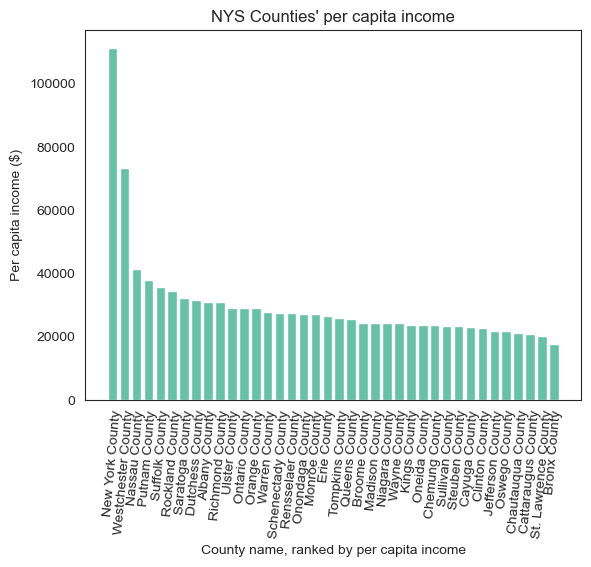

In [1942]:
#display general trend of each county (ranked by per capita income) 
#vs. their per capita income
general_graph = plt.bar(ageless_merged_df['County'], 
        ageless_merged_df['Per capita income'])
plt.title("NYS Counties' per capita income")
plt.xlabel("County name, ranked by per capita income")
plt.ylabel("Per capita income ($)")
plt.xticks(rotation=85)
display(general_graph)

This visualization is particularly interesting, it seems as though New York County and Westchester County have dramatically higher per capita incomes than the rest of the state's counties, which have relatively similar per capita incomes approximately ranging from 40,000 dollars to  20,000 dollars.

Now we will display each county's percentage of Science and Engineering majors relative to the other counties:

<Axes: title={'center': 'Percentage of Science and Engineering majors for each county'}, xlabel='County name, ranked by per capita income', ylabel='Percentage of Science and Engineering'>

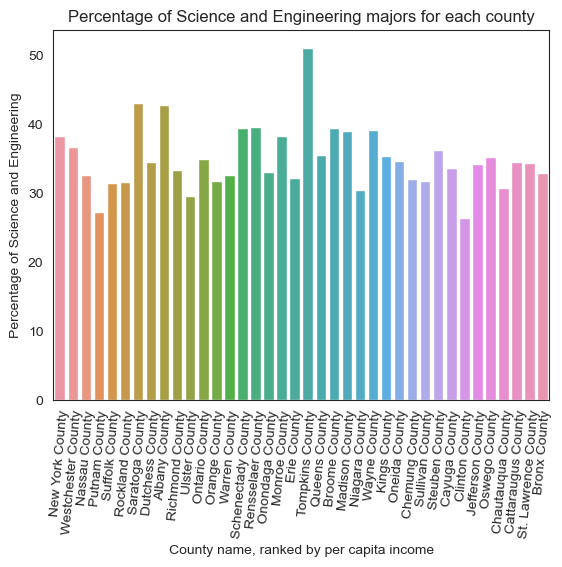

In [1943]:
science_engineering_barplot_ageless = sns.barplot(ageless_merged_df,
    x="County", y="Science \
and Engineering")
science_engineering_barplot_ageless.set_xticklabels(
    ageless_merged_df['County'],rotation=85)
science_engineering_barplot_ageless.set(
    xlabel="County name, ranked by per capita income", 
    ylabel='Percentage of Science and Engineering', 
    title='Percentage of Science and Engineering \
majors for each county')
display(science_engineering_barplot_ageless)

Tompkins County clearly has the greatest number of Science and Engineering graduates with a percentage greater than 50, while other counties fall into the range of roughly 40% to 25%. This is interesting, since Tompkins County is roughly in the middle tier of per capita income, so such a large percentage of Science and Engineering graduates is noteable.

Now we will display each county's percentage of Science and Engineering Related Fields majors relative to the other counties:

<Axes: title={'center': 'Percentage of Science and Engineering Related Fields majors for each county'}, xlabel='County name, ranked by per capita income', ylabel='Percentage of Science and Engineering Related Fields'>

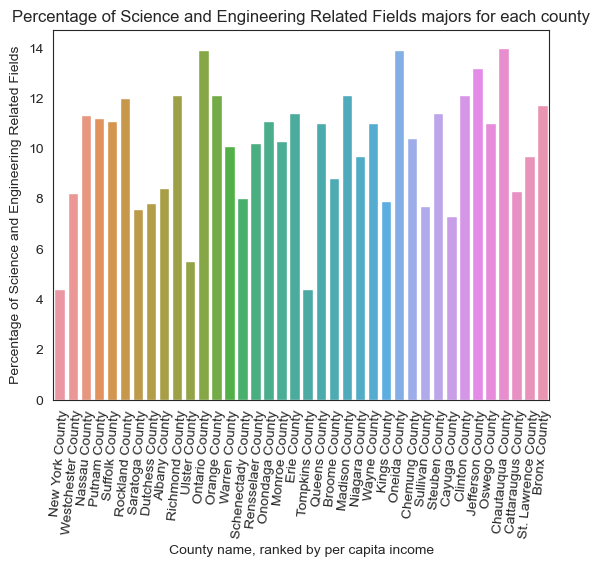

In [1944]:
science_engineering_barplot_related_ageless = sns.barplot(
    ageless_merged_df, x="County", 
    y="Science and Engineering Related Fields")
science_engineering_barplot_related_ageless.set_xticklabels(
    ageless_merged_df['County'],rotation=85)
science_engineering_barplot_related_ageless.set(
    xlabel="County name, ranked by per capita income", 
    ylabel='Percentage of Science and Engineering Related Fields', 
    title='Percentage of Science and Engineering Related Fields \
majors for each county')
display(science_engineering_barplot_related_ageless)

Overall, the category of Science and Engineering Related Fields makes up a very low percentage within each county, with its highest percentage of a county's graduates being 14% in Ontario County, Oneida County, and Chautauqua County, and its lowest being roughly 4% in New York County and in Tompkins County, despite the two counties scoring at the high end of the Science and Engineering category. Perhaps this is due to the way the data was categorized into either the Science and Engineering category or the Science and Engineering _Related_ Fields category.

Now we will display each county's percentage of Business majors relative to the other counties:

<Axes: title={'center': 'Percentage of Business majors for each county'}, xlabel='County name, ranked by per capita income', ylabel='Percentage of Business'>

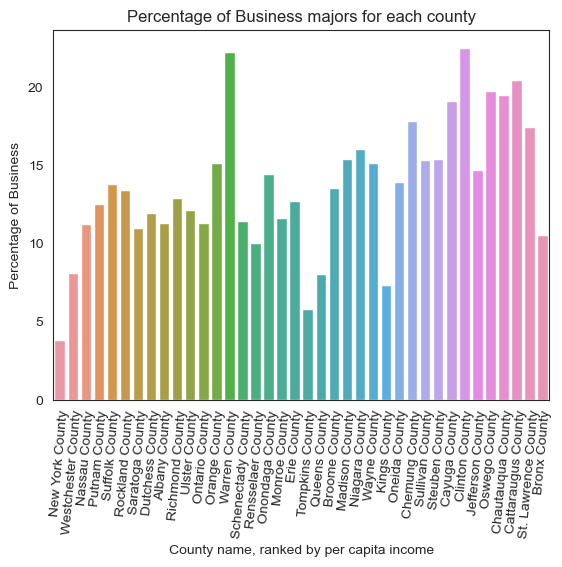

In [1945]:
business_barplot_ageless = sns.barplot(
    ageless_merged_df, x="County", y="Education")
business_barplot_ageless.set_xticklabels(
    ageless_merged_df['County'],rotation=85)
business_barplot_ageless.set(
    xlabel="County name, ranked by per capita income", 
    ylabel='Percentage of Business', 
    title='Percentage of Business majors for each county')
display(business_barplot_ageless)

There seems to be a general positive relationship between the percentage of business majors and the per capita income of a county; as per capita income decreases, the percentage of business majors seems to decrease overall.

Now we will display each county's percentage of Education majors relative to the other counties:

<Axes: title={'center': 'Percentage of Education majors for each county'}, xlabel='County name, ranked by per capita income', ylabel='Percentage of Education'>

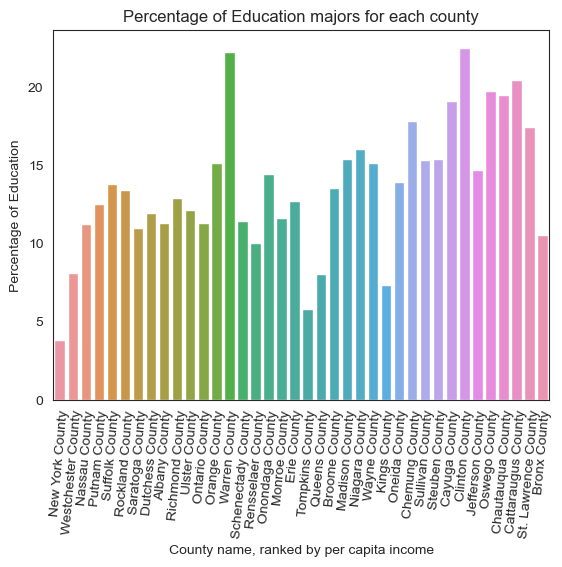

In [1946]:
education_barplot_ageless = sns.barplot(
    ageless_merged_df, x="County", y="Education")
education_barplot_ageless.set_xticklabels(
    ageless_merged_df['County'],rotation=85)
education_barplot_ageless.set(
    xlabel="County name, ranked by per capita income", 
    ylabel='Percentage of Education', 
    title='Percentage of Education majors for each county')
display(education_barplot_ageless)

The overall trend viewable in the above visualization is: as per capita income decreases, the percentage of Education degree-holders increases. An interesting outlier is Warren County, which has a much higher percentage of Education majors relative to similarly-wealthy counties. Upon inspection, the county is located very close to Albany, the capital of the state and has a sizeable population, so it may be that many educators of the metropolis live in the county. However, this claim is purely speculative and requires further investigation to validate a cause for the county's higher percentage of Education majors.

Now we will display each county's percentage of Arts, Humanities and Others majors relative to the other counties:

<Axes: title={'center': 'Percentage of Arts, Humanities and Others majors for each county'}, xlabel='County name, ranked by per capita income', ylabel='Percentage of Arts, Humanities and Others'>

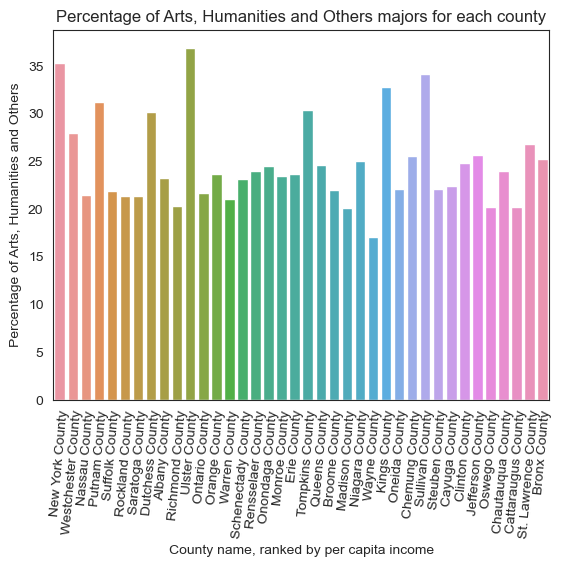

In [1947]:
arts_barplot_ageless = sns.barplot(
ageless_merged_df, x="County", y="Arts, Humanities and Others")
arts_barplot_ageless.set_xticklabels(
    ageless_merged_df['County'],rotation=85)
arts_barplot_ageless.set(
    xlabel="County name, ranked by per capita income", 
    ylabel='Percentage of Arts, Humanities and Others', 
    title='Percentage of Arts, Humanities and Others majors \
for each county')
display(arts_barplot_ageless)

There does not seem to be any discernible relationship between the percentage of arts, humanities, and other majors and the county's per capita income.

## Data Description of Analysis-Ready data

- What are the observations (rows) and the attributes (columns)?
    - For the ageless_merged_df dataframe, it has 37 rows and 7 columns. Each row is a county (they are ranked by per capita income) and the first column is the county name. The rest of the columns are each group / category of college major. The values in those columns are the percentage of the specific major in a specific county.
    - For the young_merged_df dataframe, it has 37 rows and 7 rows, all of which are the same as the ageless_merged_df dataframe, but only pertaining to the values for participants who were between the ages of 25 and 39.
    - For the middle_merged_df dataframe, it has 37 rows and 7 rows, all of which are the same as the ageless_merged_df dataframe, but only pertaining to the values for participants who were between the ages of 40 and 64.
    - For the old_merged_df dataframe, it has 37 rows and 7 rows, all of which are the same as the ageless_merged_df dataframe, but only pertaining to the values for participants who were 65 years old and older.
- What preprocessing was done, and how did the data come to be in the form that you are using?
    - We had to grab the columns from the census data that we were interested in; originally, the data had a lot of columns unrelated to the major percentage of each county. We also had to convert many string columns into floats and ints, as the % signs and the commas in the data we extracted from the Census and Wikepedia both had numerical values in the form of a string. We also had to change the names of many columns because they had unnecessarily long and verbose names, including the County names. With our cleaned data, we divided that one big dataframe into three dataframes, each one representing one age group. We merged the Wikepedia data and the big cleaned Census data we had into one. We then merged the Wikepedia dataframe with each of the three smaller dataframes for each age group. We split it into age-specific dataframes because we wanted to view the data in both an age-specific context and an age-blind context.
- What do the instances that comprise the dataset represent?
    - The data in the major-name columns represent the percentage of people in that county who reported their major as being within that category of majors.
    - The data in the county name columns represents the county being measured.

## Preregistration Hypotheses

- Hypothesis 1: Do counties with more business majors than any other major tend to be richer than counties with a lower percentage of business majors? 

- $H_0$: Counties with more business majors than any other major do not have a significant difference in wealth compared to counties with a lower percentages of business majors.
- $H_A$: Counties with more business majors than any other major do have a significant difference in wealth compared to counties with a lower percentages of business majors.

We seek to determine whether a correlation exists between college major and the wealth of a graduate's county of residency. Majoring in business typically involves positions in finance, an industry that is assumed to be profitable and lucrative. By specifically investigating a potential relationship between business major percentage and a county's wealth, we can support or counter this assumption.

Using a linear regression, we will input business major percentage as a variable and output county wealth. We will use this model to determine the correlation coefficient between the input and the output, and if it is significant or not (if the p-value is less than 0.05, we will consider it significant).

- Hypothesis 2: Do science and engineering majors tend to reside in a county with a high per capita income? 

- $H_0$: Science and engineering majors are equally as likely as other majors to reside in a county with a high per capita income.
- $H_A$: Science and engineering majors are significantly more likely than other majors to reside in a county with a high per capita income.

Similar to business, science and engineering professions have been increasingly viewed as profitable due to the rise of the technology industry. We seek to determine whether a relationship exists between science and engineering majors and the wealth of the county in which they reside in. By determining the existence of such a relationship, we can either reinforce or contradict this assumption with evidence.

Similar to the previous hypothesis, we will use a linear regression to determine the correlation coefficient between the input and the output and if it is significant, using the p-value associated with the slope.

Note: for all of the hypotheses below, we are using a significance level of 5%.

## Hypothesis 1 - Do counties with more business majors tend to be richer than counties with lower percentages of business majors?

We will investigate this hypothesis using an OLS regression fitted to the ageless dataframe we created earlier.

In [1948]:
df = ageless_merged_df[['Per capita income',
                             'Science and Engineering', 
                             'Science and Engineering Related Fields', 
                             'Business', 
                             'Education', 
                             'Arts, Humanities and Others']]
display(df)

,Per capita income,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,111386,38.3,4.4,18.3,3.8,35.3
1,73159,36.6,8.2,19.1,8.1,28.0
2,41387,32.6,11.3,23.5,11.2,21.4
3,37915,27.3,11.2,17.8,12.5,31.2
4,35755,31.5,11.1,21.7,13.8,21.9
5,34304,31.6,12.0,21.7,13.4,21.3
6,32186,43.0,7.6,17.2,11.0,21.3
7,31642,34.5,7.8,15.7,11.9,30.1
8,30863,42.8,8.4,14.3,11.3,23.2
9,30843,33.3,12.1,21.3,12.9,20.3


Now that we have the dataframe, we can extract the columns we need to fit a regression:

In [1949]:
hyp1_df = df
X = hyp1_df['Business']
y = hyp1_df['Per capita income']
X = sm.add_constant(X)
h1_model = sm.OLS(y, X)
h1_results = h1_model.fit()
print(h1_results.summary())

                            OLS Regression Results                            
Dep. Variable:      Per capita income   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     3.480
Date:                Wed, 29 Nov 2023   Prob (F-statistic):             0.0703
Time:                        11:37:29   Log-Likelihood:                -420.23
No. Observations:                  38   AIC:                             844.5
Df Residuals:                      36   BIC:                             847.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5459.5172   1.35e+04      0.406      0.6

We cannot reject the null hypothesis because the p-value is greater than 0.05. Therefore, we cannot claim that there is a linear relationship between a county's percentage of business majors and a county's per capita income.

## Hypothesis 2: Do science and engineering majors tend to reside in a county with a higher per capita income?

We will do the same procedure we did in hypothesis 1, except this time, for county percentages of Science and Engineering:

In [1950]:
hyp2_df = df
X = hyp2_df['Science and Engineering']
y = hyp2_df['Per capita income']
X = sm.add_constant(X)
h2_model = sm.OLS(y, X)
h2_results = h2_model.fit()
print(h2_results.summary())

                            OLS Regression Results                            
Dep. Variable:      Per capita income   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.4326
Date:                Wed, 29 Nov 2023   Prob (F-statistic):              0.515
Time:                        11:37:29   Log-Likelihood:                -421.75
No. Observations:                  38   AIC:                             847.5
Df Residuals:                      36   BIC:                             850.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

From this, we cannot reject the null hypothesis because the probability of the data we viewed occurring under the null hypothesis is very high (as the p-value is much greater than 0.05). Thus, we cannot claim there is a linear relationship between a county's percentage of Science and Engineering majors and a county's per capita income.

## Hypothesis 3: Can we reliably predict a county's per capita income based on its percentages of each of the 5 major categories?

We will use ageless_merged_df to fit a multivariable regression to, with the output being per capita income and the inputs being the percentages of the major categories.

In [1951]:
X = ageless_merged_df[['Science and Engineering', 
                       'Science and Engineering Related Fields',
                       'Business', 
                       'Education', 
                       'Arts, Humanities and Others']]
y = ageless_merged_df[['Per capita income']]

We will now split the data into a train set and a test set:

In [1952]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state=2950)

And then fit the regression to the train set:

In [1953]:
h3_model = LinearRegression().fit(X_train, y_train)

As we did before, we are predicting the outputs of the train set using the trained model:

In [1954]:
h3_y_hat_train = h3_model.predict(X_train)

We will now plot the residuals to see if we have to perform any transformations. If the residuals have a random distribution, we can proceed. If not, we must iterate on our model.

In [1956]:
predictions = h3_y_hat_train
residuals = y_train - predictions

Text(0.5, 1.0, 'Hypothesis 3 model residuals')

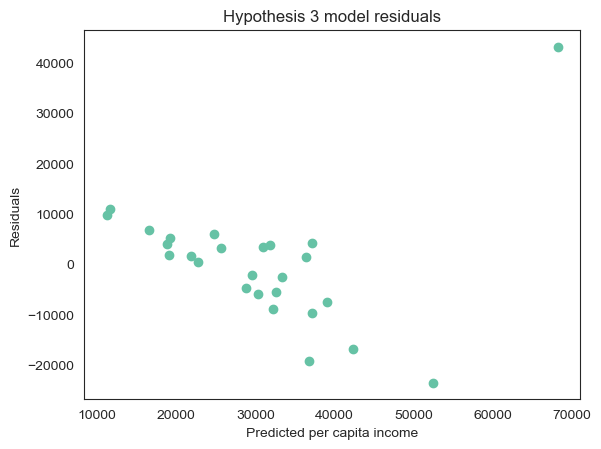

In [1957]:
plt.scatter(predictions, residuals, marker='o')
plt.xlabel('Predicted per capita income')
plt.ylabel('Residuals')
plt.title('Hypothesis 3 model residuals')

It looks as though there is a linear trend visible in the residual distribution. Thus, we have to adjust our model to account for the model's nonlinearity. There is also a concerning, very large outlier in the residuals.

And then predicting outputs for the _test_ set using the model trained on the _train_ set:

In [1955]:
h3_y_hat_test = h3_model.predict(X_test)

Now we will examine the visualization of y_test and y_hat_test to see if the predictions are reliable (we are looking for a positively sloped trend):

Text(0.5, 1.0, 'Accuracy of predictions')

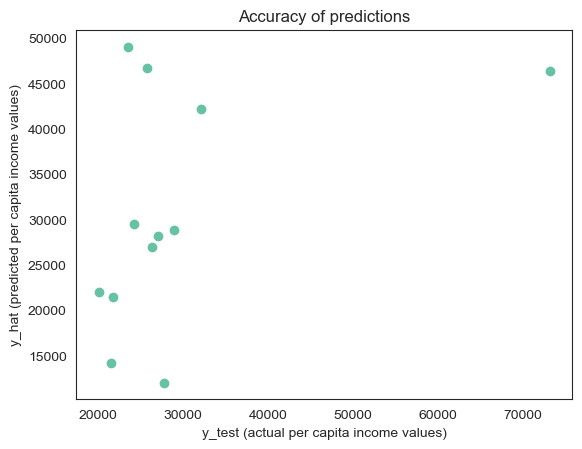

In [1958]:
plt.scatter(y_test, h3_y_hat_test)
plt.xlabel('y_test (actual per capita income values)')
plt.ylabel('y_hat (predicted per capita income values)')
plt.title('Accuracy of predictions')

We don't see a strong positive linear trend here; a slope of 1 would indicate a perfect match between the predictions and the actual per capita income values. Thus, we can conclude that we are not able to accurately predict the per capita income of a county based on the five major categories' percentages.

## Hypothesis 4 - Can we accurately predict the per capita income of a county based on its percentage of business majors?

Although we could not accurately predict the per capita income of a county based on all five major categories, we are interested in whether or not we could do so only given business major percentage.

We are now isolating the relevant columns to Hypothesis 4, namely the percentage of business majors within each county (X) and the per capita income of each county (y):

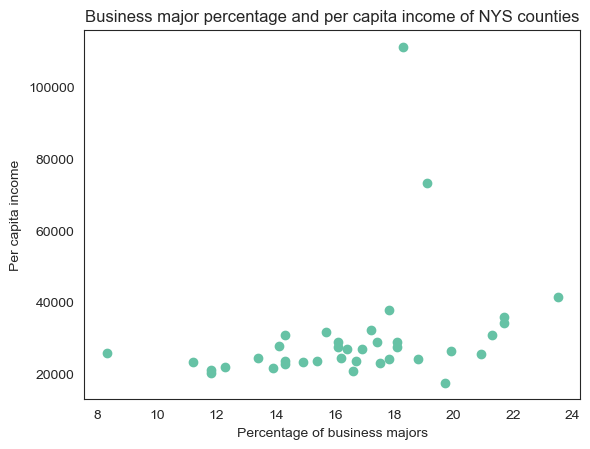

In [1959]:
X = df[['Business']]
y = df[['Per capita income']]
plt.scatter(X, y, marker='o')
plt.xlabel('Percentage of business majors')
plt.ylabel('Per capita income')
plt.title('Business major percentage and per capita income of NYS counties')
plt.show()

It seems that there is a general trend of greater percentages of business majors within a county corresponding to a greater per capita income, but there are two large outliers.

Now we are creating our train set x's and y's as well as our test set x's and y's to utilize a train-test-split on our data to be able to test our regression on "new" test data after training it:

In [1960]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state=2950)


We want to display summary statistics of our X_train data:

In [1961]:
print(X_train.describe())

        Business
count  26.000000
mean   17.015385
std     3.091626
min    11.200000
25%    15.025000
50%    16.500000
75%    18.250000
max    23.500000


In [1962]:
h4_model = LinearRegression().fit(X_train, y_train)

In the above cell, we have trained a linear regression from a train test split to predict per capita income with the percentage of business majors in each county as the input. Below, we are making predictions of per capita income given business major percentage using the train set. This allows us to view our model's predictions of per capita income (h4_y_hat_train) to our _actual_ y values (y_train)

In [1963]:
h4_y_hat_train = h4_model.predict(X_train)

As we did in Hypothesis 3, we are now checking to see if the distribution of the residuals is random. If they are, we will be able to proceed our use of the model as is.

In [1965]:
predictions = h4_y_hat_train
residuals = y_train - predictions

Text(0.5, 1.0, 'Hypothesis 4 model residuals')

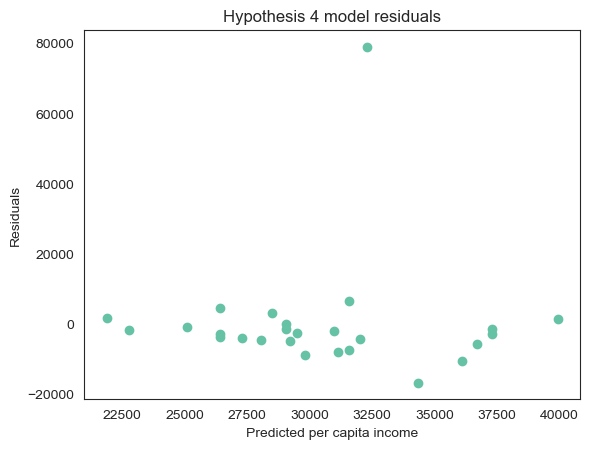

In [1967]:
plt.scatter(predictions, residuals, marker='o')
plt.xlabel('Predicted per capita income')
plt.ylabel('Residuals')
plt.title('Hypothesis 4 model residuals')

It seems as though our model has relatively random residuals, as there is no discernible pattern to the visual distribution of the residuals. There is a highly outlying point, however, which is of concern.

Now our model will use the X_&nbsp;_test_ data to predict y_test. This allows us to determine if the model works on "new" data (data it was not trained on), since the X_test data was not included in X_train. We will compare these predictions (predicted values of county per capita income) to y_test (the actual y values).

In [1964]:
h4_y_hat_test = h4_model.predict(X_test)

As we did in the previous hypothesis, we will plot the predicted outputs against the actual outputs to see if we have accurately predicted the outputs:

Text(0.5, 1.0, 'Accuracy of predictions')

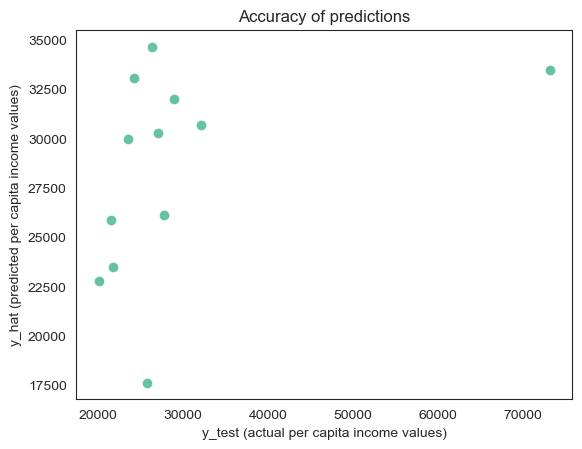

In [1898]:
plt.scatter(y_test, h4_y_hat_test)
plt.xlabel('y_test (actual per capita income values)')
plt.ylabel('y_hat (predicted per capita income values)')
plt.title('Accuracy of predictions')

This looks very similar to the plotted predictions vs. actual outputs from Hypothesis 3. There does not seem to be a strong positive trend, meaning that the model seems to be unable to accurately predict counties' per capita income given the percentage of business majors.

## Data Limitations

- The Census data is limited in that it is essentially a large sample, as it does not cover the entire population, and typically, more vulnerable groups are not represented. 
- This data and any findings from it cannot be generalized to any region outside New York State, as the only counties considered are New York State counties. Especially considering that the state has one of the biggest and most wealthy cities in the world, this is unlikely to be validly mapped to another region. In the same regard, the universities of New York residents are most likely composed of disproportionately more in-state colleges compared to other states, yet another reason to not generalize this data outside of New York. 
- Another limitation is that the Census lumps together a broad variety of majors into "STEM", "Humanities", etc. which may result in a lack of consideration of certain outliers within those major-groups. For example, Psychology may be considered STEM, but it may not follow the same trends as a Computer Science major.
- Another limitation is that the Wikepedia data is outdated by 13 years, as its most recent data is from 2010. This may be an issue because our Census data is much more recent.